<a href="https://colab.research.google.com/github/priscillaoclark/multimodal-emotion-recognition/blob/main/HODL_SP25_Final_Project_Group_40_v3_Scaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **15.773 Final Project: Multimodal Emotion Classification Using Deep Learning**

**Group 40**:                  	               Prashasti Agrawal, Priscilla Clark, Yoav Marziano, Siddharth Mehta


**Problem**: Emotion recognition from speech is a critical component of human-computer interaction. Businesses rely on this technology to detect sentiment in call center interactions, support mental health monitoring, and predict stock price movements based on company earnings calls. However, despite advancements in deep learning, current unimodal models (audio-only or text-only) fail to capture the full spectrum of emotional expression. This project aims to use state-of-the-art deep learning techniques (transformers, transfer learning) to develop a multimodal emotion classification model that integrates audio (vocal tone) and text (transcribed speech).

# **PART 1: Create features and save to CSV**

## **Step 1:** Install dependencies and import libraries

In [ ]:
!pip install --upgrade tensorflow transformers openai-whisper tensorflow_hub

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import librosa
import numpy as np
import pandas as pd
import json
from pprint import pprint
import whisper
import glob
import re
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from transformers import TFAutoModel, AutoTokenizer, Wav2Vec2Processor, TFWav2Vec2Model, TFWav2Vec2ForCTC

keras.utils.set_random_seed(42)

## **Step 2:** Download and combine datasets (RAVDESS & TESS)

We will combine two widely recognized datasets for emotional speech classification: RAVDESS and TESS.

- RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song): A dataset containing recordings of actors speaking with emotions labeled as happiness, sadness, anger, and fear.
- TESS (Toronto Emotional Speech Set): A dataset featuring speech recordings by two actresses expressing seven emotional states.

The following could also be used - but we have decided to exclude due to time constraints.
- https://www.kaggle.com/datasets/ejlok1/cremad/data
- https://www.kaggle.com/datasets/samuelsamsudinng/iemocap-emotion-speech-database/data

### **Step 2a:** Download from Kaggle

Download kaggle.json from Kaggle for API access and save in colab root directory prior to running below script

In [ ]:
import os

# Create Kaggle directory if not exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to this directory
!mv kaggle.json /root/.kaggle/

# Ensure correct file permissions
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download RAVDESS Dataset
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio --unzip -p ./datasets/ravdess/

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
100% 429M/429M [00:12<00:00, 40.8MB/s]
100% 429M/429M [00:12<00:00, 37.5MB/s]


In [ ]:
# Download TESS Dataset
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess --unzip -p ./datasets/tess/

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99% 425M/428M [00:11<00:00, 44.7MB/s]
100% 428M/428M [00:11<00:00, 39.0MB/s]


In [ ]:
# List downloaded RAVDESS files
print("RAVDESS Files:", os.listdir("./datasets/ravdess"))

# List downloaded TESS files
print("TESS Files:", os.listdir("./datasets/tess"))

RAVDESS Files: ['Actor_15', 'Actor_04', 'Actor_14', 'audio_speech_actors_01-24', 'Actor_01', 'Actor_10', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_06', 'Actor_07', 'Actor_18', 'Actor_11', 'Actor_13', 'Actor_08', 'Actor_20', 'Actor_02', 'Actor_03', 'Actor_12', 'Actor_09', 'Actor_19', 'Actor_24', 'Actor_17']
TESS Files: ['tess toronto emotional speech set data', 'TESS Toronto emotional speech set data']


### **Step 2b:** Process into dataframes and preview fields

In [ ]:
# Standardized Emotion Mapping
standardized_emotion_map = {
    "neutral": "neutral",
    "calm": "neutral",  # Merge 'calm' into 'neutral'
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "fearful": "fearful",
    "disgust": "disgust",
    "surprised": "surprised"
}

#### Load RAVDESS to df

In [ ]:
# Path to RAVDESS dataset
ravdess_path = "./datasets/ravdess/"

# Emotion mapping for RAVDESS (based on filenames)
ravdess_emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# Search for all WAV files inside subdirectories
wav_files = glob.glob(os.path.join(ravdess_path, "**/*.wav"), recursive=True)

# Extract emotion labels
ravdess_data = []
for file in wav_files:
    filename = os.path.basename(file)  # Get just the filename
    parts = filename.split("-")  # Split filename by "-"

    if len(parts) > 2:  # Ensure filename follows expected format
        emotion_code = parts[2]  # The third element corresponds to emotion
        emotion = ravdess_emotion_map.get(emotion_code, "unknown")
        standardized_emotion = standardized_emotion_map.get(emotion, "unknown")
        ravdess_data.append({"filename": filename, "emotion": standardized_emotion, "path": file})

# Convert to Pandas DataFrame
ravdess_df = pd.DataFrame(ravdess_data)
ravdess_df.head()


,filename,emotion,path
0,03-01-05-02-01-02-15.wav,angry,./datasets/ravdess/Actor_15/03-01-05-02-01-02-...
1,03-01-06-01-01-01-15.wav,fearful,./datasets/ravdess/Actor_15/03-01-06-01-01-01-...
2,03-01-04-01-01-02-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-01-01-02-...
3,03-01-04-02-02-01-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-02-02-01-...
4,03-01-04-02-01-01-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-02-01-01-...


In [ ]:
print("Unique emotions in RAVDESS:", ravdess_df["emotion"].unique())
print("Total files in RAVDESS:", len(ravdess_df))

Unique emotions in RAVDESS: ['angry' 'fearful' 'sad' 'neutral' 'happy' 'surprised' 'disgust']
Total files in RAVDESS: 2880


#### Load TESS to df

In [ ]:
# Path to TESS dataset
tess_path = "./datasets/tess/"

# TESS Emotion Mapping
tess_emotion_map = {
    "angry": "angry", "disgust": "disgust", "fear": "fearful",
    "happy": "happy", "neutral": "neutral", "sad": "sad",
    "pleasant_surprise": "surprised"
}

# Search for all WAV files in subdirectories
tess_files = glob.glob(os.path.join(tess_path, "**/*.wav"), recursive=True)
tess_data = []
for file in tess_files:
    filename = os.path.basename(file)

    # Extract emotion using regex (last word before ".wav")
    match = re.search(r"_([a-zA-Z]+)\.wav", filename)
    if match:
        emotion_key = match.group(1).lower()

        # Explicitly map "ps" to "pleasant_surprise"
        if emotion_key == "ps":
            emotion_key = "pleasant_surprise"

        emotion = tess_emotion_map.get(emotion_key, "unknown")
        standardized_emotion = standardized_emotion_map.get(emotion, "unknown")  # Standardize labels
        tess_data.append({"filename": filename, "emotion": standardized_emotion, "path": file})

# Convert to Pandas DataFrame
tess_df = pd.DataFrame(tess_data)
tess_df.head()


,filename,emotion,path
0,YAF_shout_disgust.wav,disgust,./datasets/tess/tess toronto emotional speech ...
1,YAF_vine_disgust.wav,disgust,./datasets/tess/tess toronto emotional speech ...
2,YAF_lease_disgust.wav,disgust,./datasets/tess/tess toronto emotional speech ...
3,YAF_dime_disgust.wav,disgust,./datasets/tess/tess toronto emotional speech ...
4,YAF_book_disgust.wav,disgust,./datasets/tess/tess toronto emotional speech ...


In [ ]:
print("Unique emotions in TESS:", tess_df["emotion"].unique())
print("Total files in TESS:", len(tess_df))

Unique emotions in TESS: ['disgust' 'neutral' 'happy' 'sad' 'fearful' 'angry' 'surprised']
Total files in TESS: 5600


### **Step 2c:** Combine into single dataset

In [ ]:
# Merge both datasets
combined_df = pd.concat([ravdess_df, tess_df], ignore_index=True)

In [ ]:
print("Total files in Combined Dataset:", len(combined_df))
print("Unique emotions in Combined Dataset:", combined_df["emotion"].unique())

Total files in Combined Dataset: 8480
Unique emotions in Combined Dataset: ['angry' 'fearful' 'sad' 'neutral' 'happy' 'surprised' 'disgust']


In [ ]:
print(combined_df[combined_df["emotion"] == "unknown"])


Empty DataFrame
Columns: [filename, emotion, path]
Index: []


In [ ]:
print(combined_df.shape)

(8480, 3)


In [ ]:
combined_df.head()

,filename,emotion,path
0,03-01-05-02-01-02-15.wav,angry,./datasets/ravdess/Actor_15/03-01-05-02-01-02-...
1,03-01-06-01-01-01-15.wav,fearful,./datasets/ravdess/Actor_15/03-01-06-01-01-01-...
2,03-01-04-01-01-02-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-01-01-02-...
3,03-01-04-02-02-01-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-02-02-01-...
4,03-01-04-02-01-01-15.wav,sad,./datasets/ravdess/Actor_15/03-01-04-02-01-01-...


## **Step 3:** Process audio data

Download audio models

In [ ]:
# Load Wav2Vec2 tokenizer and model
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = TFWav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Load HuBERT model
hubert_model = TFWav2Vec2Model.from_pretrained("facebook/hubert-base-ls960")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]


TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFWav2Vec2Model were not initialized from the PyTorch model and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.


tf_model.h5:   0%|          | 0.00/378M [00:00<?, ?B/s]


TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some layers from the model checkpoint at facebook/hubert-base-ls960 were not used when initializing TFWav2Vec2Model: ['hubert']
- This IS expected if you are initializing TFWav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFWav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['wav2vec2']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Function to extract audio features

Includes:

- Low-level - traditional features: MFCCs, zero-crossing rate, chroma features
- Mid-level - deep learning based: wav2vec 2.0 embeddings, HuBERT
- High-level - prosodic & energy based: pitch, formants, harmonic-to-noise ratio

The function `extract_audio_features` processes an audio file to extract a comprehensive set of features useful for speech and emotion analysis. It begins by loading the audio file using **Librosa**, ensuring a standardized sampling rate of 16,000 Hz and limiting the duration to 3 seconds. The function then extracts **traditional audio features**, including **Mel-Frequency Cepstral Coefficients (MFCCs)**, which capture the timbral characteristics of speech, **chroma features** that reflect harmonic and tonal structure, **spectral centroid** representing the "center of mass" of the frequency spectrum, **spectral rolloff** indicating the frequency below which most of the energy is concentrated, and **zero-crossing rate**, which measures how frequently the audio waveform changes sign.

To capture **high-level prosodic and energy-based features**, the function calculates **pitch (fundamental frequency, F0)**, which helps distinguish emotional expressions; **formants**, which approximate vowel resonance frequencies; **harmonic-to-noise ratio (HNR)** as a proxy for voice clarity; **jitter**, which measures variations in pitch indicative of emotional states like stress or nervousness; and **shimmer**, which quantifies amplitude variations that can signal tremors in speech. Additionally, it estimates **speech rate** by analyzing the number of speech segments detected in the given duration.

Beyond these handcrafted features, the function also extracts **deep learning-based speech embeddings**. It converts the raw audio waveform into a tensor format suitable for **pre-trained wav2vec 2.0 and HuBERT models**, which are state-of-the-art self-supervised speech models. These models generate high-dimensional embeddings that capture deep representations of speech, including phonetic, acoustic, and contextual patterns. The extracted **wav2vec and HuBERT embeddings** provide richer, more abstract features beyond traditional signal processing.

Finally, all extracted features are stored in a dictionary and returned, making them ready for downstream tasks such as emotion classification, speaker recognition, or multimodal fusion. This function effectively combines **traditional signal processing techniques** with **deep learning approaches**, ensuring robust feature extraction for speech-based applications.

In [ ]:
def extract_nonvectorized_audio_features(file_path, sr=16000, duration=3):
    # Load and resample audio
    audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)

    ### Non-Vectorized Traditional Audio Features ###
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).mean(axis=1)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate).mean(axis=1)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio).mean()

    # Prosodic & Pitch Features
    pitch, _, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    pitch_mean = np.nanmean(pitch) if np.any(~np.isnan(pitch)) else 0
    formants = librosa.lpc(audio, order=3)  # Approximate formants
    hnr = librosa.feature.rms(y=audio).mean()  # Proxy for HNR
    shimmer = np.std(np.abs(np.diff(audio)))  # Rough shimmer estimation
    speech_rate = len(librosa.effects.split(audio)[0]) / duration  # Speech rate estimation

    # Fix for jitter calculation
    if np.any(~np.isnan(pitch)):
        pitch_diff = np.diff(pitch[~np.isnan(pitch)])  # Only use non-NaN values for diff
        if len(pitch_diff) > 0:
            jitter = np.std(pitch_diff)
        else:
            jitter = 0
    else:
        jitter = 0

    feature_data = {
        # Non-Vectorized Features
        "mfccs": mfccs.tolist(),
        "chroma": chroma.tolist(),
        "spectral_centroid": spectral_centroid,
        "spectral_rolloff": spectral_rolloff,
        "zero_crossing_rate": zero_crossing_rate,
        "pitch_mean": pitch_mean,
        "formants": formants.tolist(),
        "hnr": hnr,
        "jitter": jitter,
        "shimmer": shimmer,
        "speech_rate": speech_rate,
    }

    df = pd.DataFrame([feature_data])
    return df

In [ ]:
test_audio = extract_nonvectorized_audio_features("./datasets/ravdess/Actor_06/03-01-02-01-02-02-06.wav")
test_audio.head()

,mfccs,chroma,spectral_centroid,spectral_rolloff,zero_crossing_rate,pitch_mean,formants,hnr,jitter,shimmer,speech_rate
0,"[-636.1395263671875, 54.74982452392578, -10.06...","[0.293076753616333, 0.21236777305603027, 0.168...",2174.011576,3848.819814,0.255392,284.315201,"[1.0, -0.8740952014923096, -0.3439911305904388...",0.002721,8.234928,0.001407,0.666667


In [ ]:
def extract_vectorized_audio_features(file_path, sr=16000, duration=3):
    # Load and resample audio
    audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
    audio = audio.astype(np.float32)

    # Preprocess audio using the processor
    input_values_wav2vec = wav2vec_processor(audio, return_tensors="tf", sampling_rate=sr).input_values
    input_values_hubert = input_values_wav2vec  # HuBERT expects same format

    # Extract embeddings
    wav2vec_outputs = wav2vec_model(input_values_wav2vec).last_hidden_state  # (1, seq_length, 768)
    hubert_outputs = hubert_model(input_values_hubert).last_hidden_state  # (1, seq_length, 768)

    # Mean pooling (Get a single 768D vector)
    wav2vec_embedding = tf.reduce_mean(wav2vec_outputs, axis=1).numpy().squeeze()
    hubert_embedding = tf.reduce_mean(hubert_outputs, axis=1).numpy().squeeze()

    feature_data = {
        # Vectorized Features (Embeddings)
        "wav2vec_embeddings": wav2vec_embedding.tolist(),
        "hubert_embeddings": hubert_embedding.tolist()
    }

    df = pd.DataFrame([feature_data])
    return df

In [ ]:
test_audio = extract_vectorized_audio_features("./datasets/ravdess/Actor_06/03-01-02-01-02-02-06.wav")
test_audio.head()

,wav2vec_embeddings,hubert_embeddings
0,"[0.0061107054352760315, -0.004218353424221277,...","[-1.01201331615448, -1.079369068145752, -0.414..."


## **Step 4:** Process text data (transcribe and create embeddings)

Load text models

In [ ]:
# Load text processing models
whisper_model = whisper.load_model("small")  # Choose: "base", "small", "medium", "large"
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = TFAutoModel.from_pretrained("roberta-base")

100%|███████████████████████████████████████| 461M/461M [00:08<00:00, 59.8MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Function to transcribe speech to text

In [ ]:
def transcribe_audio(file_path, method="whisper"):

    if method == "whisper":
        result = whisper_model.transcribe(file_path, fp16=False)

        return result["text"]

In [ ]:
test_transcription = transcribe_audio("./datasets/ravdess/Actor_06/03-01-02-01-02-02-06.wav")
pprint(test_transcription)

' Dogs are sitting by the door.'


Function to tokenize the text and retrieve embeddings with RoBERTa

In [ ]:
def extract_text_features(text):
    inputs = roberta_tokenizer(text, return_tensors="tf", padding=True, truncation=True)

    # Extract embeddings
    outputs = roberta_model(**inputs)

    # Extract CLS token embeddings (first token of last_hidden_state)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (batch_size, 768)

    return cls_embedding

In [ ]:
test_text = extract_text_features(test_transcription)
print(test_text.shape)
print(test_text)

(1, 768)
[[-1.36817604e-01  1.12766609e-01 -2.18757559e-02 -1.05795115e-01
   9.92210954e-02 -4.97471839e-02 -1.19463783e-02  4.49528731e-02
   3.36829834e-02 -8.43509063e-02 -4.58963402e-03  1.01793967e-02
   4.55003306e-02 -4.47808430e-02  5.46692684e-02  2.48781890e-02
  -2.50107907e-02  2.55932938e-02 -2.27520689e-02 -1.97656564e-02
  -1.13445744e-01  1.28206890e-02  2.20104717e-02  1.65653691e-01
  -5.53568564e-02  7.88756981e-02  1.10909492e-01  6.03646114e-02
  -3.95844392e-02  3.50593887e-02 -2.95155011e-02 -7.57527500e-02
   7.54920170e-02 -3.36579606e-02 -1.07808094e-02  8.92421007e-02
  -6.73021376e-03 -5.10087237e-03 -2.16794536e-02  1.39082633e-02
   8.82482529e-03  1.63754866e-01  5.07780351e-02  3.30499467e-03
   8.18831921e-02  1.33552942e-02 -1.92108676e-02 -1.61041114e-02
  -2.50707269e-02  2.43220404e-02 -1.71098262e-02  1.12181887e-01
  -5.98448552e-02  4.92260568e-02 -1.74846381e-01  6.29027188e-02
   5.99595532e-02  4.77913506e-02  4.54966910e-03 -1.10822678e-01
 

## **Step 5:** Combine audio and text features

Early fusion in machine learning refers to a data integration approach where multiple input sources or modalities (e.g., text, images, audio) are combined at the input level before being processed by a model. This method typically involves concatenating or transforming raw features from different modalities into a single unified representation. By fusing data early, the model can learn shared patterns and interactions across modalities from the start, potentially improving performance in multimodal tasks. However, early fusion can also lead to increased data complexity and higher dimensionality, which may require careful feature engineering and dimensionality reduction techniques.

### Run all functions for all files

In [ ]:
# Create a new list to store the filepaths and other data
data = []

# Iterate over the rows of the dataframe
for index, row in combined_df.head(1000).iterrows():
#for index, row in combined_df.iterrows():
    filepath = row['path']
    emotion = row['emotion']
    print(f"Processing {filepath} ({index+1}/{len(combined_df)})")
    # print(f"Emotion: {emotion}")

    # Extract audio features
    audio_nonvectorized_features = extract_nonvectorized_audio_features(filepath)
    audio_vectorized_features = extract_vectorized_audio_features(filepath)
    transcription = transcribe_audio(filepath)
    # print(f"Transcription: {transcription}")
    text_embedding = extract_text_features(transcription)

    # Append the data to the list
    audio_nonvectorized_features_dict = audio_nonvectorized_features.iloc[0].to_dict()  # Convert DataFrame row to dictionary
    audio_vectorized_features_dict = audio_vectorized_features.iloc[0].to_dict()  # Convert DataFrame row to dictionary
    data.append({
        "filepath": filepath,
        "emotion": emotion,
        **audio_nonvectorized_features_dict,  # Unpack audio features into the dictionary
        **audio_vectorized_features_dict,  # Unpack audio features into the dictionary
        "transcription": transcription,
        "text_embeddings": text_embedding.tolist()
    })

Processing ./datasets/ravdess/Actor_15/03-01-05-02-01-02-15.wav (1/8480)
Processing ./datasets/ravdess/Actor_15/03-01-06-01-01-01-15.wav (2/8480)
Processing ./datasets/ravdess/Actor_15/03-01-04-01-01-02-15.wav (3/8480)
Processing ./datasets/ravdess/Actor_15/03-01-04-02-02-01-15.wav (4/8480)
Processing ./datasets/ravdess/Actor_15/03-01-04-02-01-01-15.wav (5/8480)
Processing ./datasets/ravdess/Actor_15/03-01-05-01-01-01-15.wav (6/8480)
Processing ./datasets/ravdess/Actor_15/03-01-04-02-01-02-15.wav (7/8480)
Processing ./datasets/ravdess/Actor_15/03-01-01-01-01-01-15.wav (8/8480)
Processing ./datasets/ravdess/Actor_15/03-01-03-02-02-02-15.wav (9/8480)
Processing ./datasets/ravdess/Actor_15/03-01-08-02-02-02-15.wav (10/8480)
Processing ./datasets/ravdess/Actor_15/03-01-03-01-01-01-15.wav (11/8480)
Processing ./datasets/ravdess/Actor_15/03-01-04-01-01-01-15.wav (12/8480)
Processing ./datasets/ravdess/Actor_15/03-01-08-02-02-01-15.wav (13/8480)
Processing ./datasets/ravdess/Actor_15/03-01-08

In [ ]:
features_df = pd.DataFrame(data)
features_df.head()

,filepath,emotion,mfccs,chroma,spectral_centroid,spectral_rolloff,zero_crossing_rate,pitch_mean,formants,hnr,jitter,shimmer,speech_rate,wav2vec_embeddings,hubert_embeddings,transcription,text_embeddings
0,./datasets/ravdess/Actor_15/03-01-05-02-01-02-...,angry,"[-394.2899475097656, 49.3659553527832, -18.131...","[0.3633098304271698, 0.3439134955406189, 0.369...",2217.087582,4182.263963,0.214568,343.904122,"[1.0, -1.7675139904022217, 1.172137975692749, ...",0.031719,39.447083,0.015670,0.666667,"[-0.010515953414142132, 0.016866814345121384, ...","[-1.3655692338943481, -0.27402499318122864, -0...",Kids are talking by the door!,"[[-0.06395579874515533, 0.06708963215351105, -..."
1,./datasets/ravdess/Actor_15/03-01-06-01-01-01-...,fearful,"[-580.5211791992188, 61.22125244140625, 2.1682...","[0.6273627877235413, 0.5708147287368774, 0.518...",1481.493266,3204.621011,0.143742,187.985310,"[1.0, -1.7216876745224, 0.9443462491035461, -0...",0.006661,12.519729,0.001665,0.666667,"[-0.031390074640512466, 0.000707685190718621, ...","[-1.3542137145996094, -0.6526721119880676, -0....",Kids are talking by the door.,"[[-0.1130225658416748, 0.11561170220375061, -0..."
2,./datasets/ravdess/Actor_15/03-01-04-01-01-02-...,sad,"[-630.8934936523438, 70.11908721923828, -1.245...","[0.5334205627441406, 0.495819628238678, 0.4455...",1557.371654,3563.081782,0.130376,141.856603,"[1.0, -1.8360131978988647, 1.1705060005187988,...",0.004026,19.341450,0.001851,0.666667,"[0.004455358721315861, -0.015129689127206802, ...","[-1.3870207071304321, -0.8012237548828125, -0....",Kids are talking by the door.,"[[-0.1130225658416748, 0.11561170220375061, -0..."
3,./datasets/ravdess/Actor_15/03-01-04-02-02-01-...,sad,"[-547.1043701171875, 57.532859802246094, -14.2...","[0.43786847591400146, 0.4466301202774048, 0.40...",2127.872633,4230.053191,0.238245,179.715302,"[1.0, -1.4331868886947632, 0.7222627401351929,...",0.007070,20.735696,0.004944,0.666667,"[0.02596481889486313, -0.012004099786281586, -...","[-1.0657031536102295, -1.1405235528945923, 0.3...",Dogs are sitting by the door.,"[[-0.13681760430335999, 0.11276660859584808, -..."
4,./datasets/ravdess/Actor_15/03-01-04-02-01-01-...,sad,"[-543.5462646484375, 57.98125457763672, -2.555...","[0.5708132982254028, 0.605961799621582, 0.4862...",1659.099245,3321.226729,0.151855,192.977473,"[1.0, -1.995985984802246, 1.3818871974945068, ...",0.009220,11.404768,0.002268,0.666667,"[-0.002854350721463561, 0.0024725308176130056,...","[-0.4401894807815552, 0.5704559683799744, 0.63...",Kids are talking by the door.,"[[-0.1130225658416748, 0.11561170220375061, -0..."


#### Save to csv to prevent needing to run again at later sessions

In [ ]:
features_df.to_csv("features.csv", index=False)

### Process both vectorized features and other non-vectorized audio features

# **PART 2: Upload CSV and run models**

## **Step 6:** Import saved CSV (OK to start here)

#### Redo imports to allow starting from here

In [1]:
# Install required packages
!pip install -q tensorflow pandas matplotlib scikit-learn

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import os
from tensorflow.keras.regularizers import l2
import keras

In [3]:
# Configure GPU for TensorFlow (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"Found {len(gpus)} GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for all GPUs")
    except RuntimeError as e:
        print(f"Error configuring GPUs: {e}")

Found 1 GPUs
Memory growth enabled for all GPUs


**IMPORTANT:** Upload file at location below.

https://drive.google.com/file/d/1lA2r39Pm3d97EfY0w9DThBGRRw5uJUpq/view?usp=sharing

#### Prepare features

In [6]:
# Helper function to parse array strings from CSV
def parse_array(arr_string):
    """Convert string representation of arrays back to numpy arrays"""
    try:
        if isinstance(arr_string, str):
            # Remove brackets and split by comma
            arr_string = arr_string.strip('[]')
            return np.array([float(x) for x in arr_string.split(',')])
        else:
            # If already an array, return as is
            return arr_string
    except:
        # Return zeros if parsing fails (assuming 768 is the embedding size)
        return np.zeros(768)

# Load features from CSV file
def load_features(csv_path):
    """Load and prepare features from CSV file"""
    print(f"Loading features from {csv_path}...")
    features_df = pd.read_csv(csv_path)

    print(f"Loaded {len(features_df)} samples with {len(features_df.columns)} features")

    # Fill NaN values in numeric columns with mean values
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].mean())

    # Parse array columns from string to numpy arrays
    print("Parsing vector features...")
    array_columns = ["text_embeddings", "wav2vec_embeddings", "hubert_embeddings", "mfccs", "chroma", "formants"]
    for col in array_columns:
        if col in features_df.columns:
            print(f"Converting {col} to arrays...")
            features_df[col] = features_df[col].apply(parse_array)

    return features_df

# Extract features from dataframe
def prepare_feature_arrays(df):
    """Extract and organize feature arrays from the dataframe"""
    # Extract embeddings
    if "wav2vec_embeddings" in df.columns:
        wav2vec_embeddings = np.stack(df["wav2vec_embeddings"].values)
        print(f"wav2vec shape: {wav2vec_embeddings.shape}")
    else:
        wav2vec_embeddings = np.zeros((len(df), 768))
        print("wav2vec_embeddings not found, using zeros")

    if "hubert_embeddings" in df.columns:
        hubert_embeddings = np.stack(df["hubert_embeddings"].values)
        print(f"hubert shape: {hubert_embeddings.shape}")
    else:
        hubert_embeddings = np.zeros((len(df), 768))
        print("hubert_embeddings not found, using zeros")

    if "text_embeddings" in df.columns:
        text_embeddings = np.stack(df["text_embeddings"].values)
        print(f"text shape: {text_embeddings.shape}")
    else:
        text_embeddings = np.zeros((len(df), 768))
        print("text_embeddings not found, using zeros")

    if "mfccs" in df.columns:
        mfccs = np.stack(df["mfccs"].values)
        print(f"mfccs shape: {mfccs.shape}")
    else:
        mfccs = np.zeros((len(df), 40))
        print("mfccs not found, using zeros")

    if "chroma" in df.columns:
        chroma = np.stack(df["chroma"].values)
        print(f"chroma shape: {chroma.shape}")
    else:
        chroma = np.zeros((len(df), 12))
        print("chroma not found, using zeros")

    # Extract scalar audio features
    scalar_features = ["spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
                       "pitch_mean", "hnr", "jitter", "shimmer", "speech_rate"]

    available_scalar_features = [f for f in scalar_features if f in df.columns]

    if available_scalar_features:
        other_audio = df[available_scalar_features]
        other_audio = np.array(other_audio)
        print(f"scalar features shape: {other_audio.shape}")
    else:
        other_audio = np.zeros((len(df), 1))
        print("No scalar features found, using zeros")

    # Create fused feature sets
    # 1. Concatenate non-embedding features
    fused_features_nonembeddings = np.concatenate((mfccs, chroma, other_audio), axis=1)
    print(f"fused nonembeddings shape: {fused_features_nonembeddings.shape}")

    # 2. Concatenate non-embedding features + audio embeddings
    fused_features_audio = np.concatenate((wav2vec_embeddings, hubert_embeddings, mfccs, chroma, other_audio), axis=1)
    print(f"fused audio shape: {fused_features_audio.shape}")

    # 3. Concatenate all features
    fused_features_all = np.concatenate((wav2vec_embeddings, hubert_embeddings, text_embeddings, mfccs, chroma, other_audio), axis=1)
    print(f"fused all shape: {fused_features_all.shape}")

    # Clean up NaN values in fused features
    for feature_set in [fused_features_nonembeddings, fused_features_audio, fused_features_all]:
        nan_count = np.isnan(feature_set).sum()
        if nan_count > 0:
            print(f"Found {nan_count} NaN values, replacing with column means")
            col_means = np.nanmean(feature_set, axis=0)
            inds = np.where(np.isnan(feature_set))
            feature_set[inds] = np.take(col_means, inds[1])

    return {
        "wav2vec_embeddings": wav2vec_embeddings,
        "hubert_embeddings": hubert_embeddings,
        "text_embeddings": text_embeddings,
        "mfccs": mfccs,
        "chroma": chroma,
        "other_audio": other_audio,
        "fused_features_nonembeddings": fused_features_nonembeddings,
        "fused_features_audio": fused_features_audio,
        "fused_features_all": fused_features_all
    }

In [7]:
    csv_path = "features_complete.csv"

    # Load features
    features_df = load_features(csv_path)

    # Prepare feature arrays
    features_dict = prepare_feature_arrays(features_df)
    features_dict

Loading features from features_complete.csv...
Loaded 8480 samples with 17 features
Parsing vector features...
Converting text_embeddings to arrays...
Converting wav2vec_embeddings to arrays...
Converting hubert_embeddings to arrays...
Converting mfccs to arrays...
Converting chroma to arrays...
Converting formants to arrays...
wav2vec shape: (8480, 768)
hubert shape: (8480, 768)
text shape: (8480, 768)
mfccs shape: (8480, 40)
chroma shape: (8480, 12)
scalar features shape: (8480, 8)
fused nonembeddings shape: (8480, 60)
fused audio shape: (8480, 1596)
fused all shape: (8480, 2364)


{'wav2vec_embeddings': array([[-45.81075287, -48.23505402, -47.74915314, ...,   0.        ,
           0.        ,   0.        ],
        [-46.85514069, -52.89336777, -54.46282959, ...,   0.        ,
           0.        ,   0.        ],
        [-43.74618149, -49.62265778, -48.11420441, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [-37.09547424, -52.00594711, -60.92287827, ...,   0.        ,
           0.        ,   0.        ],
        [-32.32276535, -47.73503494, -59.49338913, ...,   0.        ,
           0.        ,   0.        ],
        [-35.45469666, -48.60761642, -61.98173904, ...,   0.        ,
           0.        ,   0.        ]]),
 'hubert_embeddings': array([[-6.64799927e+02,  6.41520615e+01,  2.44770584e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.23537537e+02,  5.68009987e+01,  8.19234943e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-7.08825439e+02,  6.40723877e+01,

In [8]:
wav2vec_embeddings = features_dict["wav2vec_embeddings"]
hubert_embeddings = features_dict["hubert_embeddings"]
text_embeddings = features_dict["text_embeddings"]
mfccs = features_dict["mfccs"]
chroma = features_dict["chroma"]
other_audio = features_dict["other_audio"]
fused_features_nonembeddings = features_dict["fused_features_nonembeddings"]
fused_features_audio = features_dict["fused_features_audio"]
fused_features_all = features_dict["fused_features_all"]

In [9]:
print("wav2vec:", wav2vec_embeddings.shape, type(wav2vec_embeddings))
print("hubert:", hubert_embeddings.shape, type(hubert_embeddings))
print("text:", text_embeddings.shape, type(text_embeddings))
print("mfccs:", mfccs.shape, type(mfccs))
print("chroma:", chroma.shape, type(chroma))
print("other:", other_audio.shape, type(other_audio))

# Fused features
print("fused nonembeddings:", fused_features_nonembeddings.shape, type(fused_features_nonembeddings))
print("fused audio:", fused_features_audio.shape, type(fused_features_audio))
print("fused all:", fused_features_all.shape, type(fused_features_all))

wav2vec: (8480, 768) <class 'numpy.ndarray'>
hubert: (8480, 768) <class 'numpy.ndarray'>
text: (8480, 768) <class 'numpy.ndarray'>
mfccs: (8480, 40) <class 'numpy.ndarray'>
chroma: (8480, 12) <class 'numpy.ndarray'>
other: (8480, 8) <class 'numpy.ndarray'>
fused nonembeddings: (8480, 60) <class 'numpy.ndarray'>
fused audio: (8480, 1596) <class 'numpy.ndarray'>
fused all: (8480, 2364) <class 'numpy.ndarray'>


#### Prepare dependent variable (emotion)

In [10]:
# Helper function to print class distribution
def print_class_distribution(y_data, emotion_names, split_name=""):
    """Print the distribution of classes in a dataset"""
    if len(y_data.shape) > 1:  # If one-hot encoded
        # Convert from one-hot to class indices
        class_counts = np.sum(y_data, axis=0)
        class_percentage = class_counts / len(y_data) * 100
    else:  # If already class indices
        unique, counts = np.unique(y_data, return_counts=True)
        class_counts = counts
        class_percentage = counts / len(y_data) * 100

    print(f"\n{split_name} Class Distribution:")
    print("-" * 40)
    print(f"{'Emotion':<15} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)

    for i, emotion in enumerate(emotion_names):
        print(f"{emotion:<15} {int(class_counts[i]):<10} {class_percentage[i]:.2f}%")

    print("-" * 40)
    print(f"Total samples: {len(y_data)}")

# Prepare target variable (emotions)
def prepare_target(df):
    """Create one-hot encoded target variables"""
    # Check if 'emotion' column exists
    if 'emotion' not in df.columns:
        raise ValueError("DataFrame does not contain 'emotion' column")

    # Get unique emotions
    unique_emotions = sorted(df['emotion'].unique())
    print(f"Found {len(unique_emotions)} emotion classes: {unique_emotions}")

    # Convert to one-hot encoded format
    emotions = pd.get_dummies(df['emotion']).to_numpy()
    print(f"Target shape: {emotions.shape}")

    # Check overall class distribution
    print_class_distribution(emotions, unique_emotions, "Overall Dataset")

    return emotions, unique_emotions

In [11]:
    # Prepare target variable
    targets, emotion_names = prepare_target(features_df)

Found 7 emotion classes: ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Target shape: (8480, 7)

Overall Dataset Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           1184       13.96%
disgust         1184       13.96%
fearful         1184       13.96%
happy           1184       13.96%
neutral         1376       16.23%
sad             1184       13.96%
surprised       1184       13.96%
----------------------------------------
Total samples: 8480


In [12]:
targets.shape, emotion_names

((8480, 7),
 ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

## **Step 7:** Define and train models

### wav2vec embeddings only

In [13]:
# Use just wav2vec_embeddings
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    wav2vec_embeddings, targets, test_size=0.2, random_state=42, stratify=targets
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (6784, 768), Test set: (1696, 768)


In [15]:
from sklearn.preprocessing import StandardScaler

# Scale AFTER train/test split to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
  # Print class distribution for both splits
  print_class_distribution(y_train, emotion_names, "Training Set")
  print_class_distribution(y_test, emotion_names, "Test Set")


Training Set Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           947        13.96%
disgust         947        13.96%
fearful         947        13.96%
happy           947        13.96%
neutral         1101       16.23%
sad             947        13.96%
surprised       948        13.97%
----------------------------------------
Total samples: 6784

Test Set Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           237        13.97%
disgust         237        13.97%
fearful         237        13.97%
happy           237        13.97%
neutral         275        16.21%
sad             237        13.97%
surprised       236        13.92%
----------------------------------------
Total samples: 1696


In [17]:
K.clear_session()

# Build model
input_layer = Input(shape=(X_train.shape[1],), name="input")
x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(input_layer)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(x)
output = Dense(len(emotion_names), activation="softmax", kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input_layer, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,663 (901.03 KB)

 Trainable params: 230,663 (901.03 KB)

 Non-trainable params: 0 (0.00 B)

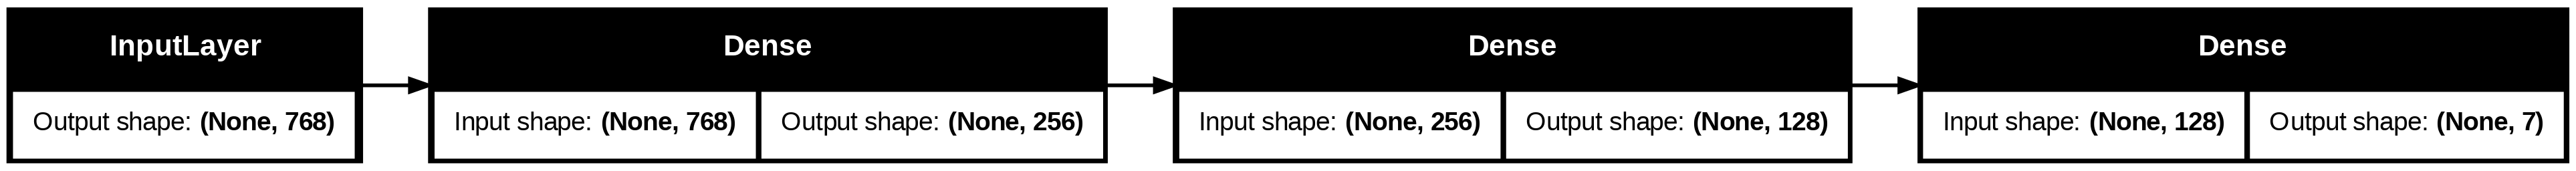

In [18]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

#### Implement overfitting prevention measures and train model

In [19]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training if val_loss does not improve for 5 epochs
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Reduce learning rate when val_loss stops improving
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

# Train the model with callbacks
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6820 - loss: 0.9271 - val_accuracy: 0.8331 - val_loss: 0.5061 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8513 - loss: 0.4442 - val_accuracy: 0.8555 - val_loss: 0.4148 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8854 - loss: 0.3516 - val_accuracy: 0.8939 - val_loss: 0.3612 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9072 - loss: 0.3030 - val_accuracy: 0.9169 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 0.2261 - val_accuracy: 0.9292 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9429 - loss: 0.2102 - val_accuracy: 0.9422 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.

In [20]:
    # Add per-epoch accuracy comparison
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("\nAccuracy by Epoch:")
    print("-" * 50)
    print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
    print("-" * 50)
    for i in range(len(train_acc)):
        diff = val_acc[i] - train_acc[i]
        print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7674           0.8331           0.0657 (Higher)
2          0.8552           0.8555           0.0003 (Higher)
3          0.8865           0.8939           0.0074 (Higher)
4          0.9130           0.9169           0.0038 (Higher)
5          0.9298           0.9292           -0.0006 (Lower)
6          0.9424           0.9422           -0.0001 (Lower)
7          0.9583           0.9340           -0.0243 (Lower)
8          0.9553           0.9245           -0.0308 (Lower)
9          0.9724           0.9487           -0.0237 (Lower)
10         0.9732           0.9599           -0.0133 (Lower)
11         0.9830           0.9652           -0.0178 (Lower)
12         0.9847           0.9664           -0.0183 (Lower)
13         0.9861           0.9575           -0.0286 (Lower)
14         0.9682         

#### Evaluate performance

In [21]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9760 - loss: 0.1389
Test Accuracy: 0.9788


#### Plot loss and accuracy

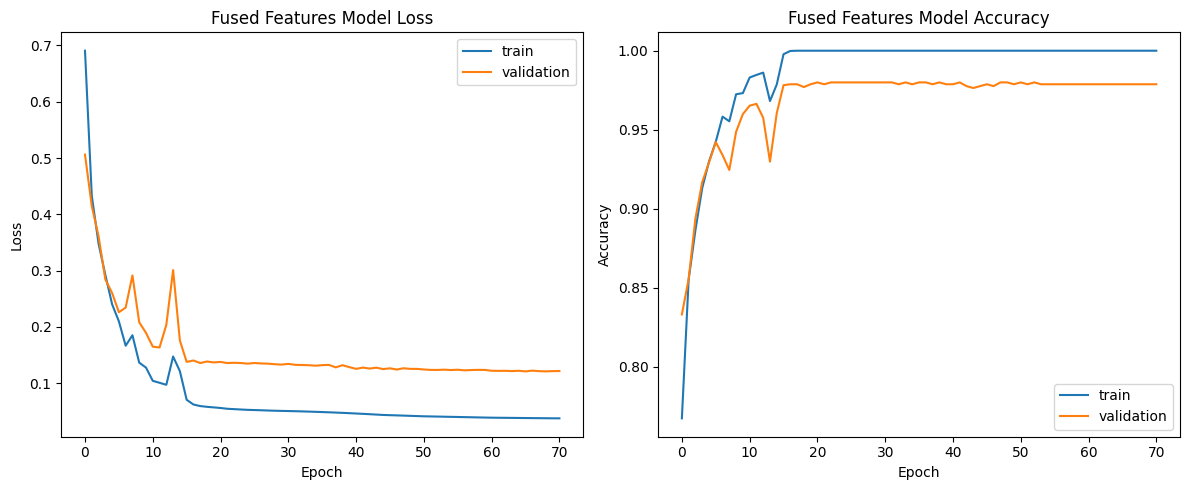

In [22]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### wav2vec + text embeddings

In [23]:
# Split dataset into training and test sets
X_train_audio, X_test_audio, X_train_text, X_test_text, y_train, y_test = train_test_split(
    wav2vec_embeddings, text_embeddings, targets, test_size=0.2, random_state=42, stratify=targets
)
print(X_train_audio.shape, y_train.shape)
print(X_test_audio.shape, y_test.shape)
print(X_train_text.shape, y_train.shape)
print(X_test_text.shape, y_test.shape)

(6784, 768) (6784, 7)
(1696, 768) (1696, 7)
(6784, 768) (6784, 7)
(1696, 768) (1696, 7)


In [24]:
scaler = StandardScaler()
X_train_audio_scaled = scaler.fit_transform(X_train_audio)
X_test_audio_scaled = scaler.transform(X_test_audio)
X_train_text_scaled = scaler.fit_transform(X_train_text)
X_test_text_scaled = scaler.transform(X_test_text)

In [25]:
K.clear_session()
audio_input = Input(shape=(X_train_audio.shape[1],), name="audio_input")
text_input = Input(shape=(X_train_text.shape[1],), name="text_input")

# Audio branch
audio_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio_input)
audio_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio_x)

# Text branch
text_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(text_input)
text_x = Dense(64, activation="relu", kernel_regularizer=l2(0.0001))(text_x)

# Merge branches
merged = Concatenate()([audio_x, text_x])

# Output layer
output = Dense(len(emotion_names), activation="softmax", kernel_regularizer=l2(0.0001))(merged)

# Build the model
model = Model(inputs=[audio_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)  │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        196,864 │ audio_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         98,432 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 7)              │          1,351 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 337,799 (1.29 MB)

 Trainable params: 337,799 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

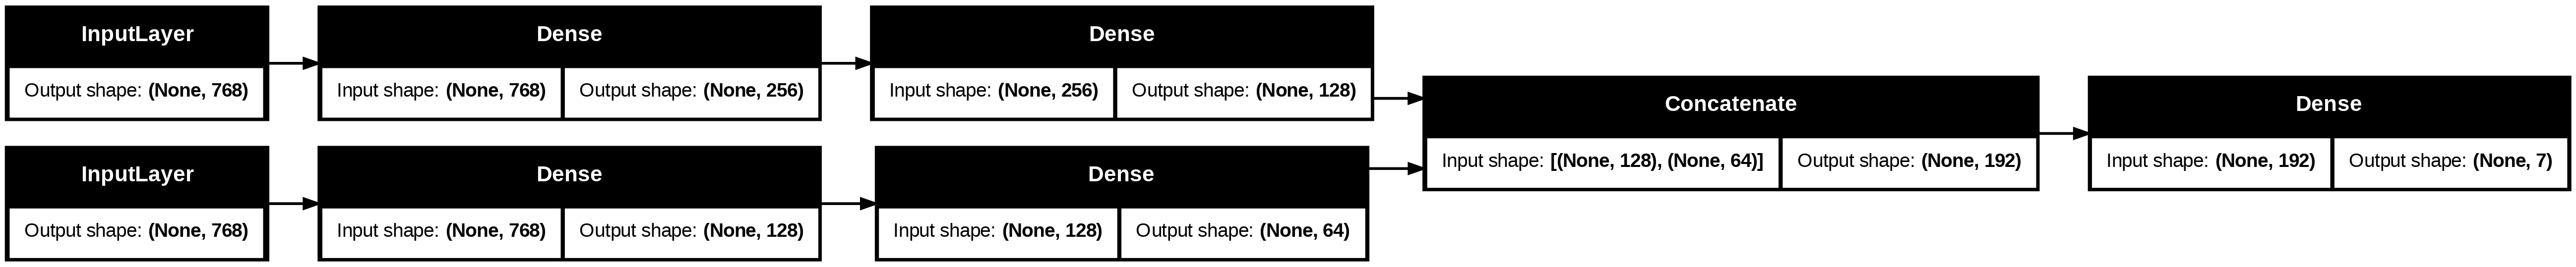

In [26]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [27]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training if val_loss does not improve for 5 epochs
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Reduce learning rate when val_loss stops improving
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

# Train model
history = model.fit(
    x=[X_train_audio_scaled, X_train_text_scaled],
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_test_audio_scaled, X_test_text_scaled], y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6676 - loss: 0.9946 - val_accuracy: 0.8160 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8509 - loss: 0.4692 - val_accuracy: 0.8703 - val_loss: 0.4498 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8895 - loss: 0.3848 - val_accuracy: 0.8726 - val_loss: 0.4220 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9107 - loss: 0.3117 - val_accuracy: 0.9139 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9304 - loss: 0.2745 - val_accuracy: 0.9192 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.2225 - val_accuracy: 0.9198 - val_loss: 0.3060 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9524 - loss: 0

In [28]:
# Add per-epoch accuracy comparison
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("\nAccuracy by Epoch:")
print("-" * 50)
print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
print("-" * 50)
for i in range(len(train_acc)):
    diff = val_acc[i] - train_acc[i]
    print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7560           0.8160           0.0600 (Higher)
2          0.8561           0.8703           0.0142 (Higher)
3          0.8902           0.8726           -0.0175 (Lower)
4          0.9085           0.9139           0.0055 (Higher)
5          0.9266           0.9192           -0.0074 (Lower)
6          0.9475           0.9198           -0.0277 (Lower)
7          0.9514           0.9204           -0.0310 (Lower)
8          0.9640           0.9393           -0.0248 (Lower)
9          0.9729           0.9552           -0.0177 (Lower)
10         0.9555           0.9363           -0.0192 (Lower)
11         0.9814           0.9658           -0.0156 (Lower)
12         0.9830           0.9475           -0.0355 (Lower)
13         0.9891           0.9717           -0.0174 (Lower)
14         0.9847         

In [29]:
# Evaluate on test set
test_loss, test_acc = model.evaluate([X_test_audio_scaled, X_test_text_scaled], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.1663
Test Accuracy: 0.9800


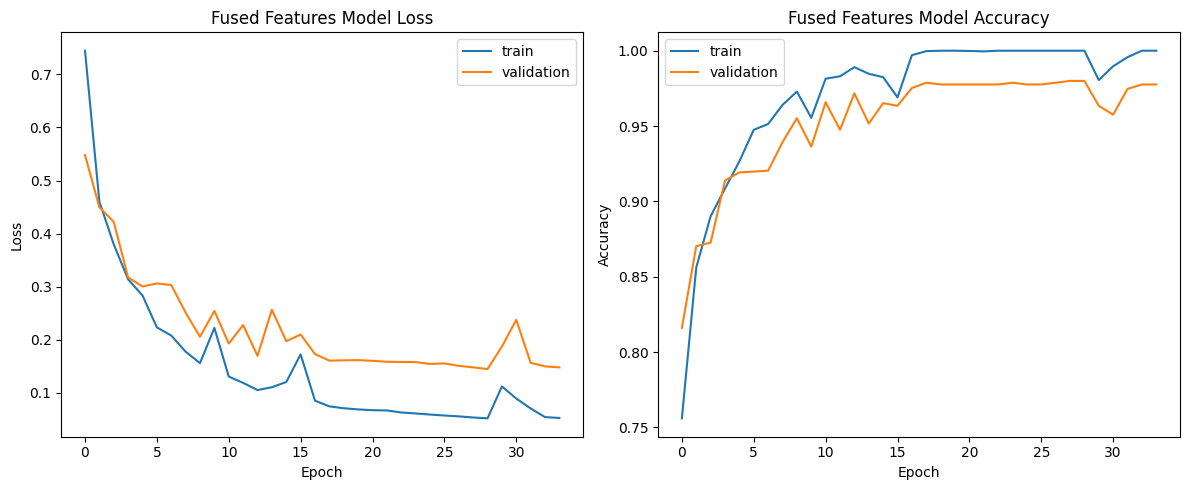

In [30]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### wav2vec, text, and hubert embeddings

In [31]:
# Split dataset into training and test sets
X_train_audio1, X_test_audio1, X_train_audio2, X_test_audio2, X_train_text, X_test_text, y_train, y_test = train_test_split(
    wav2vec_embeddings, hubert_embeddings, text_embeddings, targets, test_size=0.2, random_state=42, stratify=targets
)
print(X_train_audio1.shape, y_train.shape)
print(X_test_audio1.shape, y_test.shape)
print(X_train_audio2.shape, y_train.shape)
print(X_test_audio2.shape, y_test.shape)
print(X_train_text.shape, y_train.shape)
print(X_test_text.shape, y_test.shape)

(6784, 768) (6784, 7)
(1696, 768) (1696, 7)
(6784, 768) (6784, 7)
(1696, 768) (1696, 7)
(6784, 768) (6784, 7)
(1696, 768) (1696, 7)


In [32]:
scaler = StandardScaler()
X_train_audio1_scaled = scaler.fit_transform(X_train_audio1)
X_test_audio1_scaled = scaler.transform(X_test_audio1)
X_train_audio2_scaled = scaler.fit_transform(X_train_audio2)
X_test_audio2_scaled = scaler.transform(X_test_audio2)
X_train_text_scaled = scaler.fit_transform(X_train_text)
X_test_text_scaled = scaler.transform(X_test_text)

In [33]:
K.clear_session()
audio1_input = Input(shape=(X_train_audio1.shape[1],), name="audio1_input")
audio2_input = Input(shape=(X_train_audio2.shape[1],), name="audio2_input")
text_input = Input(shape=(X_train_text.shape[1],), name="text_input")

# Audio branches
audio1_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio1_input)
audio1_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio1_x)

audio2_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio2_input)
audio2_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio2_x)

# Text branch
text_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(text_input)
text_x = Dense(64, activation="relu", kernel_regularizer=l2(0.0001))(text_x)

# Merge branches
merged = Concatenate()([audio1_x, audio2_x, text_x])

# Output layer
output = Dense(len(emotion_names), activation="softmax")(merged)

# Build the model
model = Model(inputs=[audio1_input, audio2_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ audio1_input (InputLayer) │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio2_input (InputLayer) │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        196,864 │ audio1_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        196,864 │ audio2_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         98,432 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 320)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 7)              │          2,247 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 568,455 (2.17 MB)

 Trainable params: 568,455 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

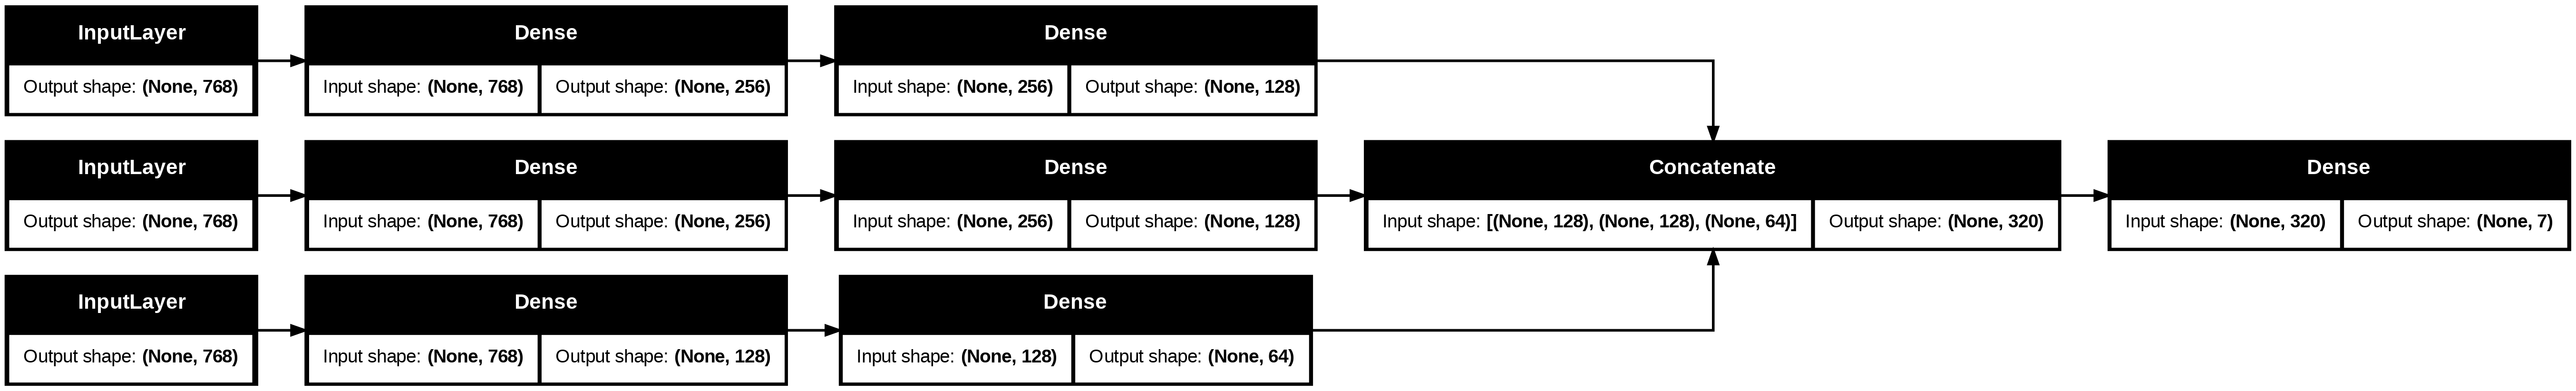

In [34]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [36]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training if val_loss does not improve for 5 epochs
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Reduce learning rate when val_loss stops improving
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

# Train model
history = model.fit(
    x=[X_train_audio1_scaled, X_train_audio2_scaled, X_train_text_scaled],
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_test_audio1_scaled, X_test_audio2_scaled, X_test_text_scaled], y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6958 - loss: 0.9431 - val_accuracy: 0.8603 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8820 - loss: 0.4293 - val_accuracy: 0.9027 - val_loss: 0.3636 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9197 - loss: 0.3146 - val_accuracy: 0.9127 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9376 - loss: 0.2742 - val_accuracy: 0.9346 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9556 - loss: 0.2173 - val_accuracy: 0.9399 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9645 - loss: 0.1967 - val_accuracy: 0.9528 - val_loss: 0.2381 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9708 - loss: 0.

In [37]:
# Add per-epoch accuracy comparison
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("\nAccuracy by Epoch:")
print("-" * 50)
print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
print("-" * 50)
for i in range(len(train_acc)):
    diff = val_acc[i] - train_acc[i]
    print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7833           0.8603           0.0769 (Higher)
2          0.8875           0.9027           0.0152 (Higher)
3          0.9219           0.9127           -0.0091 (Lower)
4          0.9375           0.9346           -0.0029 (Lower)
5          0.9499           0.9399           -0.0100 (Lower)
6          0.9611           0.9528           -0.0083 (Lower)
7          0.9615           0.9452           -0.0164 (Lower)
8          0.9754           0.9517           -0.0237 (Lower)
9          0.9830           0.9705           -0.0125 (Lower)
10         0.9853           0.9688           -0.0165 (Lower)
11         0.9937           0.9688           -0.0249 (Lower)
12         0.9823           0.9688           -0.0136 (Lower)
13         0.9848           0.9776           -0.0072 (Lower)
14         0.9903         

In [38]:
# Evaluate performance
test_loss, test_acc = model.evaluate([X_test_audio1_scaled, X_test_audio2_scaled, X_test_text_scaled], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.1220
Test Accuracy: 0.9847


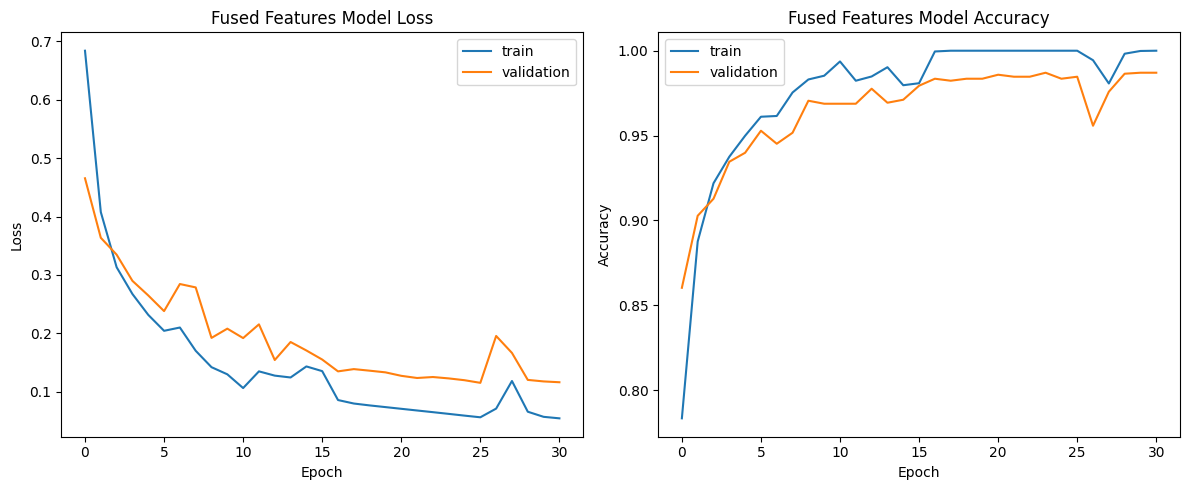

In [39]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### wav2vec, text, and hubert embeddings + regular audio features

In [40]:
# Split dataset into training and test sets
X_train_audio1, X_test_audio1, X_train_audio2, X_test_audio2, X_train_audio3, X_test_audio3, X_train_text, X_test_text, y_train, y_test = train_test_split(
    wav2vec_embeddings, hubert_embeddings, fused_features_audio, text_embeddings, targets, test_size=0.2, random_state=42, stratify=targets
)
print(X_train_audio1.shape, y_train.shape)
print(X_test_audio1.shape, y_test.shape)
print(X_train_audio2.shape, y_train.shape)
print(X_test_audio2.shape, y_test.shape)
print(X_train_audio3.shape, y_train.shape)
print(X_test_audio3.shape, y_test.shape)
print(X_train_text.shape, y_train.shape)
print(X_test_text.shape, y_test.shape)

(6784, 768) (6784, 7)
(1696, 768) (1696, 7)
(6784, 768) (6784, 7)
(1696, 768) (1696, 7)
(6784, 1596) (6784, 7)
(1696, 1596) (1696, 7)
(6784, 768) (6784, 7)
(1696, 768) (1696, 7)


In [41]:
scaler = StandardScaler()
X_train_audio1_scaled = scaler.fit_transform(X_train_audio1)
X_test_audio1_scaled = scaler.transform(X_test_audio1)
X_train_audio2_scaled = scaler.fit_transform(X_train_audio2)
X_test_audio2_scaled = scaler.transform(X_test_audio2)
X_train_audio3_scaled = scaler.fit_transform(X_train_audio3)
X_test_audio3_scaled = scaler.transform(X_test_audio3)
X_train_text_scaled = scaler.fit_transform(X_train_text)
X_test_text_scaled = scaler.transform(X_test_text)

In [42]:
K.clear_session()
audio1_input = Input(shape=(X_train_audio1.shape[1],), name="audio1_input")
audio2_input = Input(shape=(X_train_audio2.shape[1],), name="audio2_input")
audio3_input = Input(shape=(X_train_audio3.shape[1],), name="audio3_input")
text_input = Input(shape=(X_train_text.shape[1],), name="text_input")

# Audio branches
audio1_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio1_input)
audio1_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio1_x)

audio2_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio2_input)
audio2_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio2_x)

audio3_x = Dense(512, activation="relu", kernel_regularizer=l2(0.0001))(audio3_input)
audio3_x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(audio3_x)
audio3_x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(audio3_x)

# Text branch
text_x = Dense(128, activation="relu")(text_input)
text_x = Dense(64, activation="relu")(text_x)

# Merge branches
merged = Concatenate()([audio1_x, audio2_x, audio3_x, text_x])
merged = Dense(128, activation="relu")(merged)

# Output layer
output = Dense(len(emotion_names), activation="softmax")(merged)

# Build the model
model = Model(inputs=[audio1_input, audio2_input, audio3_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ audio3_input (InputLayer) │ (None, 1596)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio1_input (InputLayer) │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio2_input (InputLayer) │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        817,664 │ audio3_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        196,864 │ audio1_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        196,864 │ audio2_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │        131,328 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         98,432 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         32,896 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 448)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_6[0][0],         │
│                           │                        │                │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         57,472 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 7)              │            903 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,606,471 (6.13 MB)

 Trainable params: 1,606,471 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

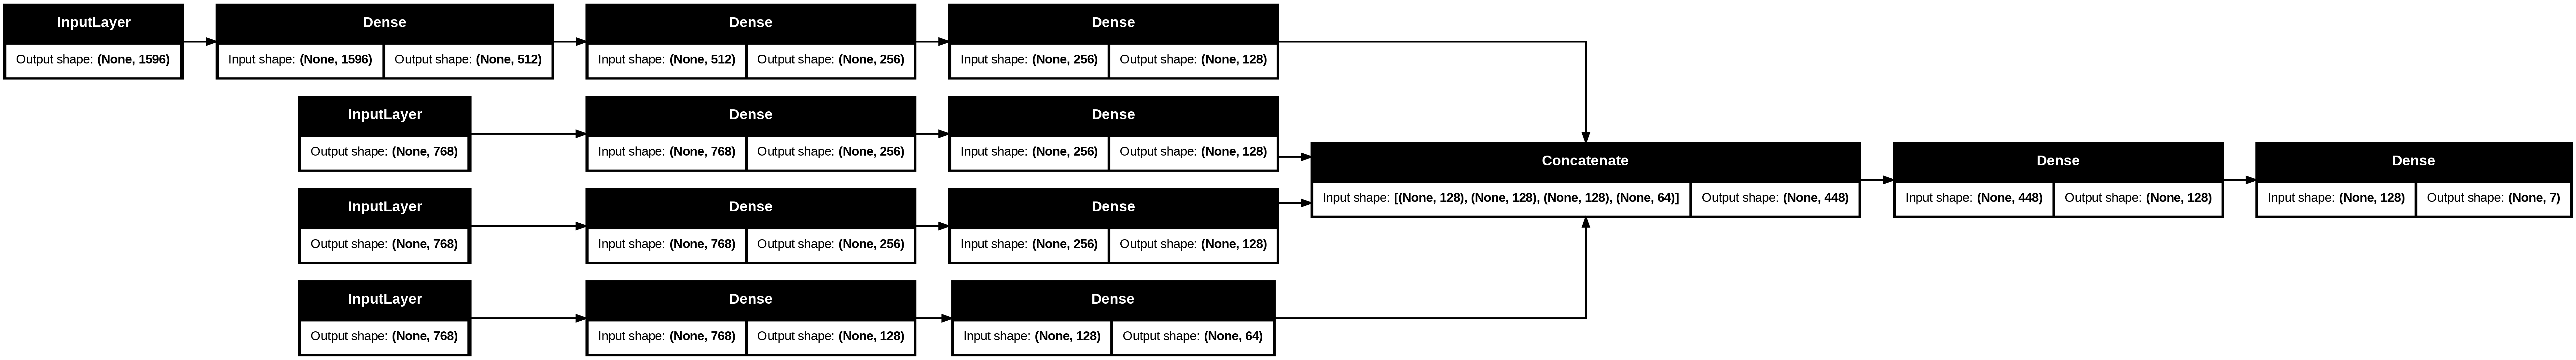

In [43]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [44]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training if val_loss does not improve for 5 epochs
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Reduce learning rate when val_loss stops improving
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

# Train the model
history = model.fit(
    x=[X_train_audio1_scaled, X_train_audio2_scaled, X_train_audio3_scaled, X_train_text_scaled],
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_test_audio1_scaled, X_test_audio2_scaled, X_test_audio3_scaled, X_test_text_scaled], y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7150 - loss: 0.9452 - val_accuracy: 0.8538 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8630 - loss: 0.4888 - val_accuracy: 0.8927 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9040 - loss: 0.4141 - val_accuracy: 0.9098 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9288 - loss: 0.3277 - val_accuracy: 0.9304 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9424 - loss: 0.2987 - val_accuracy: 0.9316 - val_loss: 0.3260 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9605 - loss: 0.2513 - val_accuracy: 0.9487 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9675 - loss: 

In [45]:
# Add per-epoch accuracy comparison
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("\nAccuracy by Epoch:")
print("-" * 50)
print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
print("-" * 50)
for i in range(len(train_acc)):
    diff = val_acc[i] - train_acc[i]
    print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7911           0.8538           0.0626 (Higher)
2          0.8721           0.8927           0.0206 (Higher)
3          0.9030           0.9098           0.0068 (Higher)
4          0.9282           0.9304           0.0022 (Higher)
5          0.9407           0.9316           -0.0091 (Lower)
6          0.9592           0.9487           -0.0105 (Lower)
7          0.9658           0.9463           -0.0195 (Lower)
8          0.9705           0.9540           -0.0165 (Lower)
9          0.9736           0.9611           -0.0125 (Lower)
10         0.9727           0.9581           -0.0146 (Lower)
11         0.9698           0.9634           -0.0063 (Lower)
12         0.9844           0.9670           -0.0174 (Lower)
13         0.9844           0.9705           -0.0139 (Lower)
14         0.9802         

In [46]:
# Evaluate performance
test_loss, test_acc = model.evaluate([X_test_audio1_scaled, X_test_audio2_scaled, X_test_audio3_scaled, X_test_text_scaled], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.0993
Test Accuracy: 0.9811


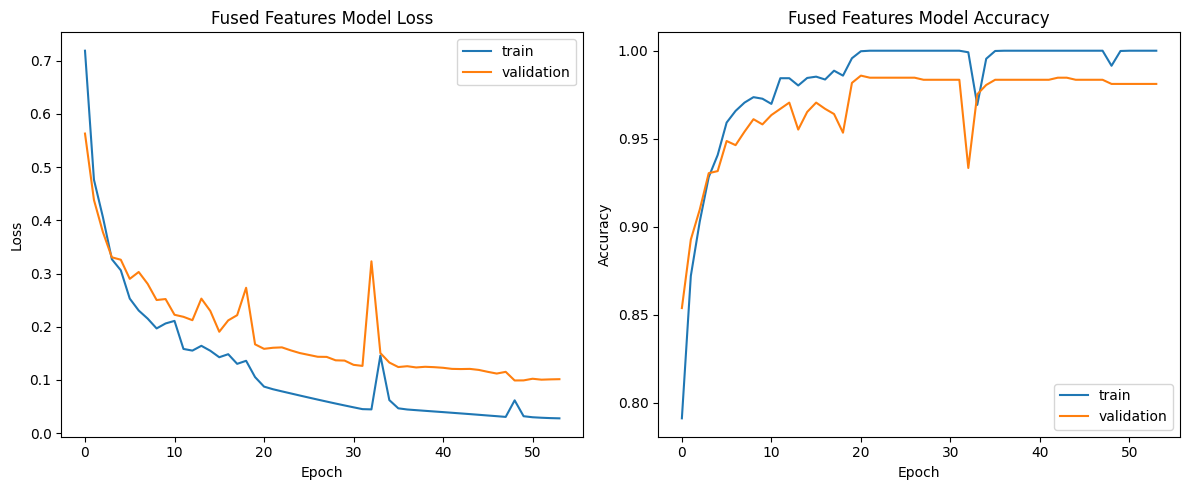

In [47]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### all fused features (without dropout)

In [62]:
# Split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    fused_features_all, targets, test_size=0.2, random_state=42, stratify=targets
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (6784, 2364), Test set: (1696, 2364)


In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
K.clear_session()
input = Input(shape=(X_train.shape[1],), name="input")

x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(input)
x = BatchNormalization()(x)

x = Dense(512, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)

x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)

output = Dense(len(emotion_names), activation="softmax", kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 2364)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,421,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,086,855 (11.78 MB)

 Trainable params: 3,083,271 (11.76 MB)

 Non-trainable params: 3,584 (14.00 KB)

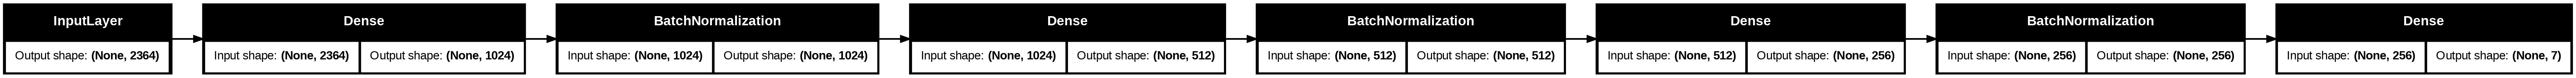

In [65]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [66]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train model with sample weights
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6481 - loss: 1.2402 - val_accuracy: 0.8272 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8164 - loss: 0.6856 - val_accuracy: 0.8390 - val_loss: 0.6749 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8452 - loss: 0.6261 - val_accuracy: 0.8443 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8546 - loss: 0.5850 - val_accuracy: 0.8384 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8747 - loss: 0.5511 - val_accuracy: 0.8620 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8753 - loss: 0.5179 - val_accuracy: 0.8656 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8858 - loss: 0.

In [67]:
# Add per-epoch accuracy comparison
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("\nAccuracy by Epoch:")
print("-" * 50)
print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
print("-" * 50)
for i in range(len(train_acc)):
    diff = val_acc[i] - train_acc[i]
    print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7388           0.8272           0.0884 (Higher)
2          0.8272           0.8390           0.0118 (Higher)
3          0.8479           0.8443           -0.0035 (Lower)
4          0.8588           0.8384           -0.0203 (Lower)
5          0.8750           0.8620           -0.0130 (Lower)
6          0.8713           0.8656           -0.0057 (Lower)
7          0.8843           0.8774           -0.0069 (Lower)
8          0.8819           0.8349           -0.0470 (Lower)
9          0.8900           0.8514           -0.0386 (Lower)
10         0.8936           0.8844           -0.0091 (Lower)
11         0.9214           0.9057           -0.0158 (Lower)
12         0.9341           0.8838           -0.0503 (Lower)
13         0.9348           0.9057           -0.0292 (Lower)
14         0.9329         

In [68]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.1677
Test Accuracy: 0.9835


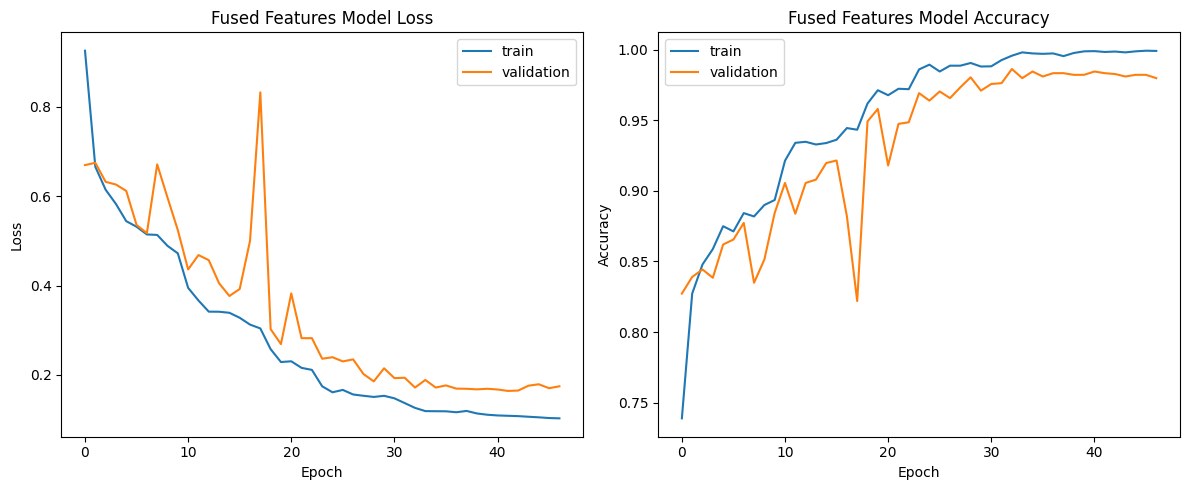

In [69]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### all fused features (with dropout)

In [70]:
# Split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    fused_features_all, targets, test_size=0.2, random_state=42, stratify=targets
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (6784, 2364), Test set: (1696, 2364)


In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
input = Input(shape=(X_train.shape[1],), name="input")
input.shape

(None, 2364)

In [73]:
K.clear_session()
input = Input(shape=(X_train.shape[1],), name="input")

x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(len(emotion_names), activation="softmax", kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 2364)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,421,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,086,855 (11.78 MB)

 Trainable params: 3,083,271 (11.76 MB)

 Non-trainable params: 3,584 (14.00 KB)

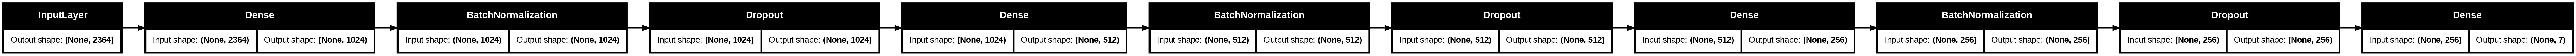

In [74]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [75]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train model with sample weights
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5808 - loss: 1.4226 - val_accuracy: 0.7978 - val_loss: 0.7563 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7896 - loss: 0.7692 - val_accuracy: 0.8096 - val_loss: 0.7262 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8082 - loss: 0.7217 - val_accuracy: 0.8290 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8385 - loss: 0.6619 - val_accuracy: 0.8603 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8399 - loss: 0.6256 - val_accuracy: 0.8502 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8517 - loss: 0.6061 - val_accuracy: 0.8703 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8639 - loss: 0.

In [76]:
# Add per-epoch accuracy comparison
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("\nAccuracy by Epoch:")
print("-" * 50)
print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
print("-" * 50)
for i in range(len(train_acc)):
    diff = val_acc[i] - train_acc[i]
    print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.6772           0.7978           0.1206 (Higher)
2          0.7901           0.8096           0.0195 (Higher)
3          0.8177           0.8290           0.0114 (Higher)
4          0.8368           0.8603           0.0234 (Higher)
5          0.8436           0.8502           0.0066 (Higher)
6          0.8524           0.8703           0.0178 (Higher)
7          0.8561           0.8585           0.0024 (Higher)
8          0.8611           0.8797           0.0186 (Higher)
9          0.8704           0.8738           0.0034 (Higher)
10         0.8772           0.8449           -0.0323 (Lower)
11         0.8784           0.8950           0.0167 (Higher)
12         0.8802           0.9092           0.0290 (Higher)
13         0.8850           0.8785           -0.0065 (Lower)
14         0.8950         

In [77]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.1925
Test Accuracy: 0.9853


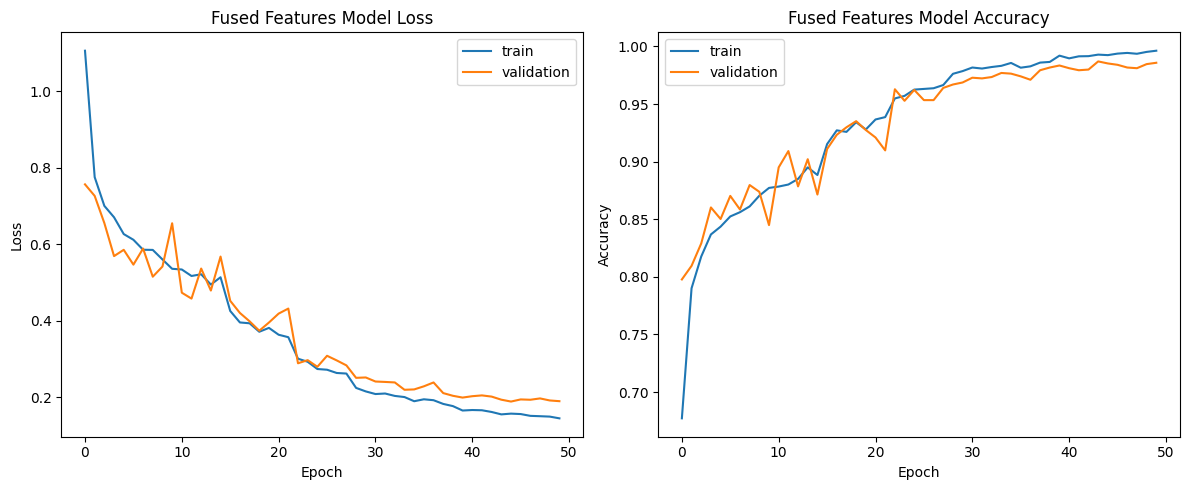

In [78]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


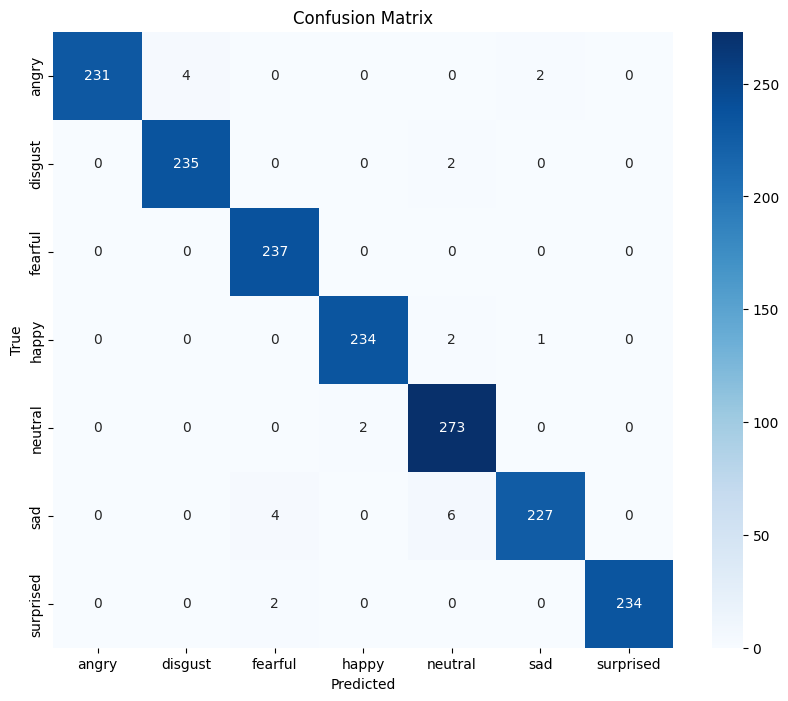

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()